The process can be defined from ($\varphi, \lambda, Q$) where
* $\varphi$ is the ODE dynamics - or the integral path defined by a vector field $\Phi$
* $\lambda$ is the probability that a jumps occurs during the particle's movement
* $Q$ is the Markov kernel used for the jump

ZigZag sampler:

* $\Phi(x, v)$ = v
* $\lambda(x, v)_i = (v_i (\partial \psi(x))_i)_+$, with $\pi \propto \exp(-\psi(x))$ the target distribution. For Gaussian distribution: $$\lambda(x, v)_i = (v_i x_i)_+ $$
* Q reverses speed.

For the reverse process, we essentially just need to compute, for all $i$:
$$ \bar \lambda_i = \lambda_i \dfrac{p_t(x_t, R_i v_t)}{p_t(x_t, v_t)} $$
Notations:
$$ s_{\theta}(x, R v, t) = \begin{pmatrix} s_{\theta}(x, R_1 v, t)_1 \\ \cdots \\ s_{\theta}(x, R_d v, t)_d \end{pmatrix}$$
where $R_i v = \begin{pmatrix} v_1 \\ \cdot \\ -v_i \\ \cdot \\ v_n \end{pmatrix}$
* Fit the model by minimizing:
     $$ \mathbb{E}_{t, x, v} \|  s_{\theta}(x, v, t) - \dfrac{p_t(x_t, R v_t)}{p_t(x_t, v_t)}\|^2 =  \mathbb{E}_{t, x, v} \frac12 s_{\theta}(x, v, t)^2 - s_{\theta}(x, R v, t)$$



Current Limitations
* If the dimension is $d$, we need $d+1$ forward pass, because:
$$ \mathbb{E}_{t, x, v} \frac12 s_{\theta}(x, v, t)^2 - s_{\theta}(x, R v, t) = \mathbb{E}_{t, x, v} \sum_{i=1}^d \frac12 s_{\theta}(x, v, t)_i^2 - s_{\theta}(x, R_i v, t)_i$$
* The loss is unstable.

**Symmetrised ratio matching** we introduce the function $g(r) = \frac{1}{1+r}$ and define the objective function
\begin{equation}
    J_{ERM}(\theta) = \sum_{i=1}^d \mathbb{E}_{p_t}\left[ \left(g(s_\theta(X_t,V_t,t)[i]) - g(r_i(X_t,V_t,t)) \right)^2 + \left(g(s_\theta(X_t,R_iV_t,t)[i]) - g(r_i(X_t,R_iV_t,t)) \right)^2 \right]
\end{equation}
which is equivalent, as an objective function, to:
\begin{equation}
    J_{IRM}(\theta) = \sum_{i=1}^d \mathbb{E}_{p_t}\left[ \frac{1}{(1 + s_\theta(x,v,t)[i])^2} +\frac{1}{(1 + s_\theta(x,R_i v,t)[i])^2}  - \frac{2}{1 + s_\theta(x,v,t)[i]}\right]
\end{equation}


**KL minimisation** Focus on the score entropy:
\begin{equation}
    J_{ERM}(\theta) =  \sum_{i=1}^d w_i\mathbb{E}_{p_t}\left[ s_\theta(X_t,V_t,t)[i] -r_i(X_t,V_t,t)  - \Big( \log s_\theta(X_t,R_iV_t,t)[i]) - \log r_i(X_t,R_iV_t,t)\Big) \right].
\end{equation}
where $\{w_i\}$ is a sequence of weights. Also this objective function considers the error in the estimation of both $r_i(x,v,t)$ and $r_i(x,R_iv,t)$, encouraging stable solutions. Clearly the implicit formulation has objective function 
\begin{equation}
    J_{IRM}(\theta) =  \sum_{i=1}^d w_i\mathbb{E}_{p_t}\left[ s_\theta(X_t,V_t,t)[i] -  \log s_\theta(X_t,R_iV_t,t)[i]) \right].
\end{equation}


TODO:
* Mixing time of pdmp (time horizon?). (Andrea)
* Dimension problem. Think of it today: first architecture is outputting (Dario)
$$r_t(x, v)_1, r_t(x, R_1v)_1, \cdots$$ 
Second one: (Dario)
$$r_t(x, 1, v_{[2:d]})_1, r_t(x, -1, v_{[2:d]})_1, \cdots$$
Third one: (Andrea)
Coordinate descent on the loss 
* Monte-Carlo to plot real density ratio, 1d and 2d, compare with model. (Dario)
* Add evaluation metrics, and loss metrics. (Dario)
* Experiments: 
    * Other datasets. $\mathcal{N}(\mu, \sigma^2 I_2)$ instead of mixture. (Dario).
    * Increase dimensions of the data distribution (Dario).
    * Study effect of the number of reverse steps. Effect of the backward sampling (spliting scheme) (Dario)


Connect to github, maybe andrea has his own branch, and then you can update the code. 


* Architecture. Change the network architecture. Receives $R$ as an argument, and is made invariant on speed?
    $$ s_{\theta}(x, v, R) : \quad  s_{\theta}(x, Rv, R) = s_{\theta}(x, v, R)$$ 
    Take the component $i$ as an input. Idea of copula? Take a single dimension as input too? outputs a single value.

# PDMP

## Playground

In [ ]:
# Import required packages
import torch
import numpy as np
import normflows as nf
import zuko

from matplotlib import pyplot as plt

from tqdm import tqdm

In [ ]:
# Neural spline flow (NSF) with 3 sample features and 5 context features
model = zuko.flows.NSF(2, 1, transforms=3, hidden_features=[128] * 3)

In [ ]:
# Set up model

# Define 2D Gaussian base distribution
base = nf.distributions.base.DiagGaussian(2)

# Define list of flows
num_layers = 32
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1+1, 64, 64, 2], init_zeros=True) # 3 additional condition dimensions
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(base, flows)

In [ ]:
# Move model on GPU if available
enable_cuda = True
device = 'mps' #torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

In [ ]:
# Define target distribution
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

num_samples = 10000
target_0 = nf.distributions.TwoMoons().sample(num_samples)
context_0 = torch.zeros(num_samples).unsqueeze(-1)
target_1 = nf.distributions.CircularGaussianMixture().sample(num_samples)
context_1 = torch.ones(num_samples).unsqueeze(-1)
target = torch.cat((target_0, target_1), dim=0)
context = torch.cat((context_0, context_1), dim=0)
# shuffle entries of target
idx = torch.randperm(target.shape[0])
target = target[idx]
context = context[idx]

dataset = TensorDataset(target, context) #attached a class to the data, will be useful on other datasets
data = DataLoader(dataset, 
                batch_size=target.shape[0] // 8, 
                shuffle=True, 
                num_workers=0)

In [ ]:
loss_hist = np.array([])
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5) # 5e-4

In [ ]:
# Train model
max_iter = 1000

it = 0
for it in tqdm(range(0, max_iter, len(data))):
    for _, (x, context) in (enumerate(data)):
        optimizer.zero_grad()
        
        # Get training samples
        #x = target.sample(num_samples).to(device)
        x, context = x.to(device), context.to(device)
        
        # Compute loss
        #loss = model.forward_kld(x, context=context)
        loss = -model(context).log_prob(x)
        loss = loss.mean()

        # Do backprop and optimizer step
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optimizer.step()
        
        # Log loss
        loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    if (it% (50*len(data))) == 0:
        print('Loss: ', loss)
    #print('Loss: ', loss)

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

In [ ]:
# Plot target distribution
f, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 7))
# Plot target distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

#log_prob = target.log_prob(zz).to('cpu').view(*xx.shape)
#prob = torch.exp(log_prob)
#prob[torch.isnan(prob)] = 0
# Plot learned distribution
model.eval()
log_prob = model(0*torch.ones(zz.shape[0], 1).to(device)).log_prob(zz).to('cpu').view(*xx.shape) #model.log_prob(zz, 0*torch.ones(zz.shape[0], 1)).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

ax[0].pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')

ax[0].set_aspect('equal', 'box')
ax[0].set_axis_off()
ax[0].set_title('TwoMoons, class 0', fontsize=24)

# Plot learned distribution
model.eval()
log_prob = model(1*torch.ones(zz.shape[0], 1).to(device)).log_prob(zz).to('cpu').view(*xx.shape)#model.log_prob(zz, 1*torch.ones(zz.shape[0], 1)).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

ax[1].pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')

ax[1].set_aspect('equal', 'box')
ax[1].set_axis_off()
ax[1].set_title('Gaussian Circle, class 1', fontsize=24)

plt.subplots_adjust(wspace=0.1)

plt.show()

In [ ]:
model(torch.zeros(10, 1).to(device)).sample()

## Setup

* Forward, backward, loss in PDMP class
* Other classes automatically take care of training, evaluation, saving, loading etc

Prepare all our objects:

In [ ]:
from IPython.display import HTML
from IPython.display import display
import os
import yaml
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

import numpy as np
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import initial_code.pdmp as PDMP
import Data as Data
from Model import LevyDiffusionModel
import torch.optim as optim
import torch.nn as nn
import Generate as Gen
import matplotlib.pyplot as plt
import evaluate.Eval as Eval
import Manager 
import zuko

%matplotlib inline

p_model_2d = {
    'act' : 'silu',
    'skip_connection' : True,
    'group_norm' : True,
    'dropout_rate' : .0,
    'nblocks' : 32,
    'nunits' : 64,
    'use_a_t' : False,
    'no_a': True,
    'a_pos_emb': False, # cannot have no_a and a_pos_emb
    'a_emb_size': 32,
    'time_emb_type' : 'learnable',#'learnable',# 'one_dimensional_input',
    'time_emb_size' : 8, 
    'compute_gamma': False,
}

p_data_2d = {
    'nfeatures' : 2, # if data_type is 2d, will just project on first dimension
    'nsamples' : 4*8*1024,
    #'bs': ..., may need to add
    'dataset' : 'gmm_2',
    'std' : 0.1, # 0.5, 0.05,
    'n_mixture' : 2, # must be square. set to None if not a grid mixture
    'normalize' : True,
    #'weights': np.array([1/2]*2),
    'weights': None,#[.01, .1, .3, 
               # .2, .02, .15,
               # .02, .15, .05],# None, #np.array([.05, .95]),
    'theta': 1.,
    'alpha': 2.,
    #'isotropic': True
}

device = 'mps'
# device = 'cpu'

# original data, get dataloader
gmm_2 = Data.Generator(**p_data_2d)#('gmm_2', n_samples = 32000, theta=1, std = 0.1)
GMM2 = gmm_2.generate()
GMM2 = GMM2.unsqueeze(1) # add channel
dataset = TensorDataset(GMM2, torch.tensor([0.]).repeat(GMM2.shape[0])) #attached a class to the data, will be useful on other datasets
data = DataLoader(dataset, 
                batch_size=p_data_2d['nsamples'] // 8, 
                shuffle=True, 
                num_workers=0)

# model
#model = LevyDiffusionModel({'data': {'nfeatures': p_data_2d['nfeatures']}, 'model':p_model_2d, 'device': 'cpu'}).to(device)
# Neural spline flow (NSF) with 3 sample features and 5 context features
model = zuko.flows.NSF(2, 3, transforms=3, hidden_features=[128] * 3).to(device)

# optimizer
optimizer = optim.AdamW(model.parameters(), 
                        lr=5e-4, 
                        betas=(0.9, 0.99)) # beta_2 0.95 instead of 0.999

# PDMP class
pdmp = PDMP.PDMP(time_horizon = 10, reverse_steps = 250, device=device, sampler_name='BPS', refresh_rate = 0.5)

# Manager for data generation
gen_model = Gen.GenerationManager(model, pdmp, data)

eval_class = Eval.Eval(model, pdmp, data, is_image=False)
manager = Manager.Manager(model, 
                 data,
                 pdmp, 
                 optimizer,
                 learning_schedule = None,
                 eval = eval_class,
                 ema_rates = None,)


## Look at the noised data

In [ ]:
# can use this to load a model, optimizer, learning schedule, and eval metrics

MODEL_PATH = 'models/model.pt'
EVAL_PATH = 'models/eval_model.pt'

manager.load(MODEL_PATH)
manager.load_eval_metrics(EVAL_PATH)

In [ ]:
# clone data, since it will be modified by forward process
data_clone = GMM2.clone()
# orint its shape
print(data_clone.shape)
# # get a unit time horizon
time_horizons = torch.ones(data_clone.shape)
for i in range(int(pdmp.T)):
    t = time_horizons.clone()
    pdmp.forward(data_clone, t)
#* pdmp.T
# forward process for pmdp.T time units
#pdmp.forward(data_clone, time_horizons)

In [ ]:
# look at histogram of one component at the last timestep

pos = data_clone.squeeze(1) # remove channel dimension
import scipy.stats as stats
X = np.linspace(-3, 3, 100)
Y = stats.norm.pdf(X, 0, 1)
plt.plot(X, Y, color='red')
plt.hist(pos[:, 0], bins='auto', density=True)
plt.show()

* Still need some work to get to the Monte-Carlo estimation for every possible values of speed.

In [ ]:
# clone data, since it will be modified by forward process
M = 1
L = []
lims = 3
T = np.linspace(0, 5, 100)
for t in T:
    # Define the number of bins in each dimension
    num_bins = 100  # You can adjust this value as needed
    tmp = []
    for m in range(M):
        data_clone = GMM2.clone()
        pdmp.forward(data_clone, torch.ones(data_clone.shape)*t)
        data_clone = data_clone.clamp(-lims, lims).squeeze(1).numpy()
        # Compute the 2D histogram
        hist, x_edges, y_edges = np.histogram2d(data_clone[:,0], data_clone[:,1], bins=num_bins, range=[[-lims, lims], [-lims, lims]], density=True)
        tmp.append(hist)
        # 'hist' contains the 2D histogram values
        # 'x_edges' and 'y_edges' are the bin edges in the x and y dimensions, respectively
    tmp = np.array(tmp)
    tmp = tmp.mean(axis = 0)
    L.append(tmp)
L = np.array(L)

In [ ]:
plt.imshow(L[5], origin='lower', aspect='auto')#extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
plt.colorbar()  # Add a color bar to indicate the scale
plt.xlabel('X')  # Label for the x-axis
plt.ylabel('Y')  # Label for the y-axis
plt.title('p_t(x) Heatmap')  # Title of the heatmap
plt.show()  # Display the heatmap

## Train the model

In [5]:
from IPython.display import HTML
from IPython.display import display
import os
import yaml
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

import numpy as np
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import initial_code.pdmp as PDMP
import Data as Data
from Model import LevyDiffusionModel
import torch.optim as optim
import torch.nn as nn
import Generate as Gen
import matplotlib.pyplot as plt
import evaluate.Eval as Eval
import Manager 
import zuko

%matplotlib inline

p_model_2d = {
    'act' : 'silu',
    'skip_connection' : True,
    'group_norm' : True,
    'dropout_rate' : .0,
    'nblocks' : 32,
    'nunits' : 64,
    'use_a_t' : False,
    'no_a': True,
    'a_pos_emb': False, # cannot have no_a and a_pos_emb
    'a_emb_size': 32,
    'time_emb_type' : 'learnable',#'learnable',# 'one_dimensional_input',
    'time_emb_size' : 8, 
    'compute_gamma': False,
}

p_data_2d = {
    'nfeatures' : 2, # if data_type is 2d, will just project on first dimension
    'nsamples' : 4*8*1024,
    #'bs': ..., may need to add
    'dataset' : 'gmm_2',
    'std' : 0.1, # 0.5, 0.05,
    'n_mixture' : 2, # must be square. set to None if not a grid mixture
    'normalize' : True,
    #'weights': np.array([1/2]*2),
    'weights': None,#[.01, .1, .3, 
               # .2, .02, .15,
               # .02, .15, .05],# None, #np.array([.05, .95]),
    'theta': 1.,
    'alpha': 2.,
    #'isotropic': True
}

device = 'mps'
# device = 'cpu'

# original data, get dataloader
gmm_2 = Data.Generator(**p_data_2d)#('gmm_2', n_samples = 32000, theta=1, std = 0.1)
GMM2 = gmm_2.generate()
GMM2 = GMM2.unsqueeze(1) # add channel
dataset = TensorDataset(GMM2, torch.tensor([0.]).repeat(GMM2.shape[0])) #attached a class to the data, will be useful on other datasets
data = DataLoader(dataset, 
                batch_size=p_data_2d['nsamples'] // 8, 
                shuffle=True, 
                num_workers=0)

# model
#model = LevyDiffusionModel({'data': {'nfeatures': p_data_2d['nfeatures']}, 'model':p_model_2d, 'device': 'cpu'}).to(device)
# Neural spline flow (NSF) with 3 sample features and 5 context features
model = zuko.flows.NSF(2, 3, transforms=3, hidden_features=[128] * 3).to(device)

# optimizer
optimizer = optim.AdamW(model.parameters(), 
                        lr=5e-4, 
                        betas=(0.9, 0.99)) # beta_2 0.95 instead of 0.999

# PDMP class
pdmp = PDMP.PDMP(time_horizon = 10, reverse_steps = 200, device=device, sampler_name='BPS', refresh_rate = 1.)

# Manager for data generation
gen_model = Gen.GenerationManager(model, pdmp, data)

eval_class = Eval.Eval(model, pdmp, data, is_image=False)
manager = Manager.Manager(model, 
                 data,
                 pdmp, 
                 optimizer,
                 learning_schedule = None,
                 eval = eval_class,
                 ema_rates = None,)


In [6]:
for i in range(0, 1):
    manager.train(nepochs = 50) #progress_epoch=True)
    manager.evaluate()
manager.save('models/model.pt')
manager.save_eval_metrics('models/eval_model.pt')

100%|██████████| 200/200 [00:25<00:00,  7.71it/s]


wasserstein
	losses_batch = 2.5943233966827393
	wass = 0.08295591396474346
	precision = 0.8520988707923467
	recall = 0.9810221460688213
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.912026925880624
	f_1_dc = 0.0
	fig = Figure(640x480)


In [ ]:
manager.display_evals('losses_batch', log_scale=False)

In [ ]:
manager.display_evals('losses', log_scale=False)

In [ ]:
manager.display_evals('wass', log_scale=True)

In [ ]:
manager.display_evals('recall', log_scale=False)

In [ ]:
manager.display_evals('precision', log_scale=False)

As usual, $F_1$ score is:
$$ F_1 = 2\dfrac{\textrm{precision} \cdot \textrm{recall}}{\textrm{precision} + \textrm{recall}}$$ 

In [ ]:
manager.display_evals('f_1_pr', log_scale=False)

In [ ]:
for i in [-1]:
    display(manager.eval.evals['fig'][i])

# Reverse Sampling

## Inspect generated data trajectory - from noise to data distribution

In [7]:
gen_model = Gen.GenerationManager(model, pdmp, data)
gen_model.generate(1000)

In [ ]:
# Look at the position of the particle through time
# print(gen_model.history.shape)
pos = gen_model.history.squeeze(-2)[:,2, :2]
# print(pos.shape) # squeeze: remove channel dimension
plt.plot(pos[:, 0], pos[:, 1], linestyle='-')
plt.grid(True)
plt.show()

We can now use our GenerationManager object to examine the generated data.

* get animation

In [ ]:
# Use Generation manager object to generate animation from the history of the data
gen_model.animation(generated_data_name = 'check')

* Get plot of the generated data.

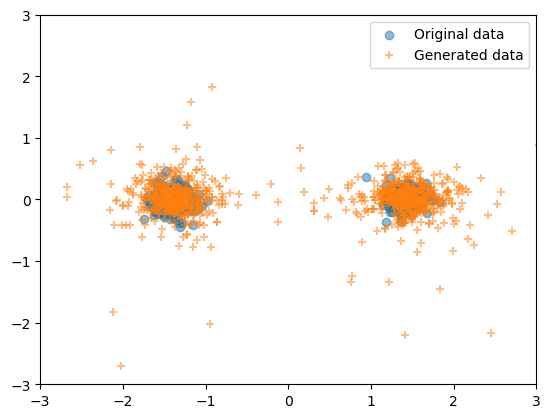

In [10]:
lims = 3
# gen_model.samples = chain[-1, :, :, :2].squeeze(-2) # get the last position of every sample, remove channel dimension
gen_model.get_plot(limit_nb_orig_data = 200, # number of original data to plot
                   xlim = (-lims, lims), ylim = (-lims, lims))